# Visualization and inspection
* Visualize importances, globally, locally.
* Trace influential variables to input clusters.
* Scatter influential variables against y
* Plot shap contributions to y = f(x)

In [1]:
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import shap
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.utils import collapse_restore_multiindex
from Weave.models import HybridExceedenceModel
from Weave.inspection import ImportanceData, MapInterface, data_for_shapplot, yplot, dotplot, barplot, mapplot, scatterplot
#logging.basicConfig(level = logging.DEBUG)
shap.initjs()

In [5]:
basepath = Path('/nobackup_1/users/straaten/')
#basepath = Path('/scistor/ivm/jsn295/')
# Latest results:
quantile = 0.8 # options: 0.666 and 0.8
permimppath = basepath / f'permimp_val_q0{str(quantile)[2:]}'
shappath = basepath / f'shap_stdback_val_q0{str(quantile)[2:]}'
#shappath = basepath / f'shap_pathdep_val_q0{str(quantile)[2:]}'
inputpath = basepath / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 
anompath = basepath / 'processed'

## Amount of input clusters
Independent of the response aggregation. Just dependent on the moment in time before the separation starts.

In [9]:
Xin = pd.read_parquet(inputpath / 'precursor.multiagg.parquet') # All are double because both spatcov and mean was extracted
Xin = Xin.loc[:, Xin.columns.get_loc_level('spatcov','metric')[0]].iloc[-1,:] # Only one timeslice needed.

In [17]:
counts.loc[('sst_nhplus',31,-46)]

separation  metric 
-15         spatcov    2.0
Name: 2019-08-31 00:00:00, dtype: float64

In [22]:
groups = list(Xin.index.names)
groups.remove('clustid')
counts = Xin.groupby(groups).count()
# neccessary for the new cv-approach. To average over folds
groups.remove('fold')
counts = counts.groupby(groups).mean()
counts.index = pd.MultiIndex.from_frame(counts.index.to_frame().assign(respagg = 7)) # To make sure that a unique respagg is present such that non-unique separation becomes the x-var 
counts.name = 'mean_number_of_clusters_over_folds'

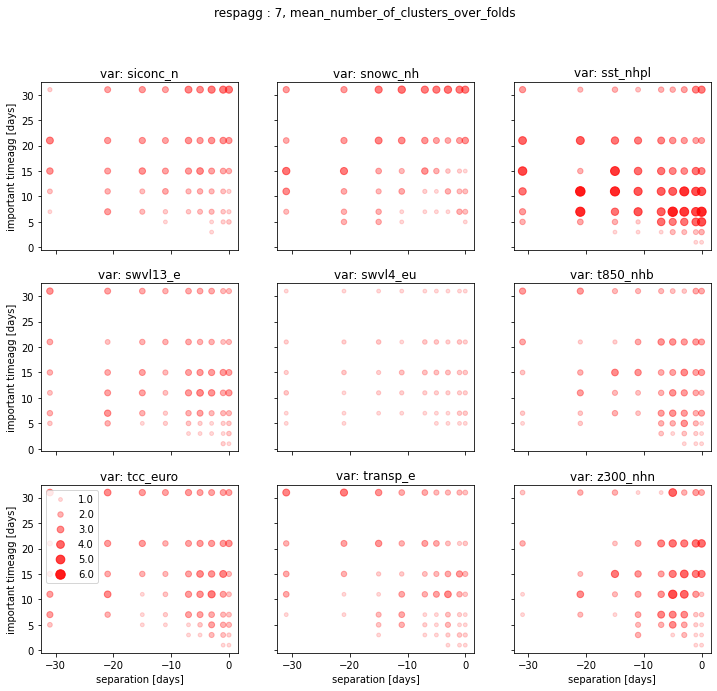

In [23]:
fig, axes = dotplot(counts, alphascaler = 0.15, nlegend_items=6, sizescaler=15)

## Importance of input

In [3]:
respagg_of_interest = [7] # [0,1,3,5,7,11,15,21,31]
separation_of_interest = [0,-1,-3,-5,-7,-11,-15,-21,-31] # -15
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)

Shap specific

In [4]:
shaps = ImportanceData(shappath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
shaps.load_data(inputpath=inputpath, X_too = True, y_too = True)
shaps.global_shap() # Reduces the column (time) axis.
shaps.reduce_over('metric', how = 'max')
shaps.reduce_over('clustid', how = 'mean') # Now max and or sum are doable (we have made absolute the large negative probabilistic influences)
shaps.reduce_over('fold', how = 'mean') # Reduce over the folds.

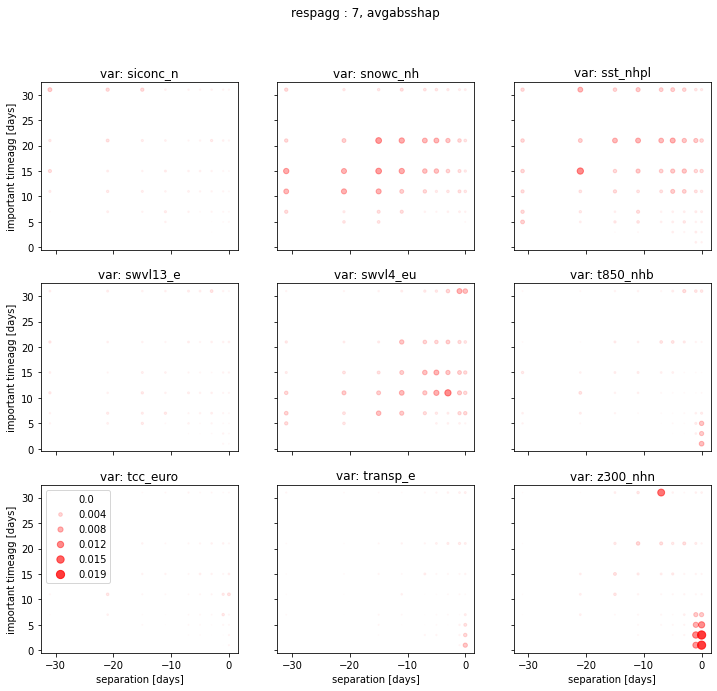

In [5]:
fig, axes = dotplot(shaps.df.iloc[:,0], alphascaler = 40, sizescaler=3500, nlegend_items=6)

Shaps basically show more divergence in importance between the separations and between variables. There is no normalization per prediction situations. It is actual probabilistic impact (not a rank of it) and impact will be larger for the most confident prediction situations. 

At respagg 31 there is some role for swvl and snow cover. But not that much over all data. With max per fold the effect changes a bit. Transpiration, tcc, t850, z300 lack in impact.

permutation importance specific

In [14]:
permimps = ImportanceData(permimppath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
permimps.load_data(inputpath = inputpath, X_too = True, y_too = True)
permimps.scale_within(fill_na = True) # This scales within ['respagg','separation','fold'], so gets one model fit onto scale [0,1]
permimps.reduce_over('clustid', how = 'max') # Max does not equal sum here. Though it is similar in character (there are no negative importances)
permimps.reduce_over('metric', how = 'max')
#perm.df = perm.df.iloc[perm.df.index.get_loc_level('spatcov',level = 'metric')[0],:] # Selecting only one metric
permimps.reduce_over('fold', how = 'mean') # Mean equals sum here because the amount of folds is equal.

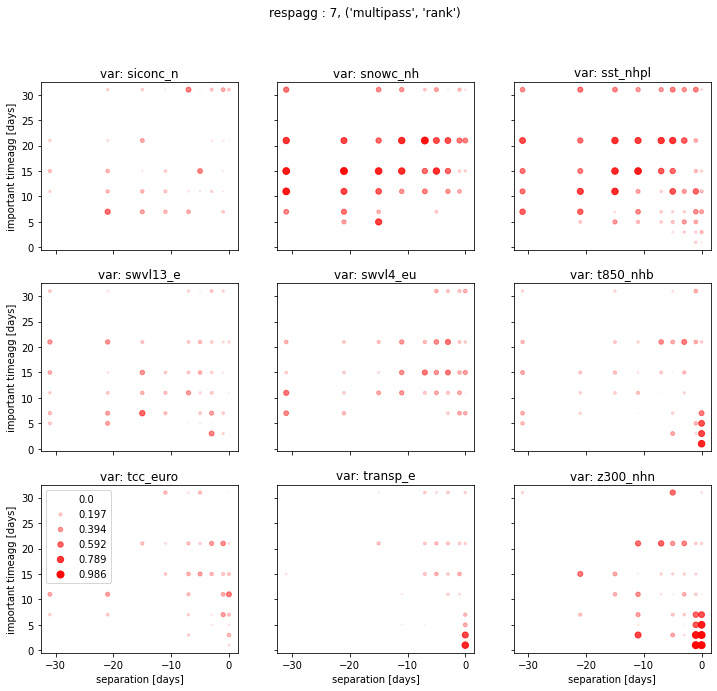

In [15]:
fig, axes = dotplot(permimps.df.iloc[:,2], alphascaler = 1, nlegend_items=6)

### Look at most important per fold and map to regions

In [4]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shappath, respagg=31, separation= [-15], quantile = quantile, model=model)
shaps.load_data(inputpath = inputpath)
shaps.global_shap() # Reduces the column axis.

In [5]:
mapint = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=shaps)

(<Figure size 288x288 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'avgabsshap'}>]], dtype=object))

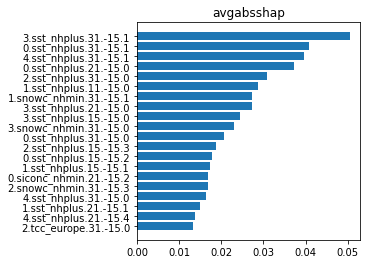

In [6]:
barplot(shaps.df.loc[([31],)],n_most_important=20)

Projecting the influence of t850, first globally and with the anomaly for a specific time.

Rowkeys are thinned, so you could be losing some information here if not also present in the xarray name or attributes


(<Figure size 864x504 with 11 Axes>,
 array([[<AxesSubplot:title={'center':'fold = 0, separation = -15, timeagg = 31'}, ylabel="(0, 't850_nhblock', 31, -15)">,
         <AxesSubplot:title={'center':'fold = 1, separation = -15, timeagg = 31'}>,
         <AxesSubplot:title={'center':'fold = 2, separation = -15, timeagg = 31'}>],
        [<AxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}, ylabel="(3, 't850_nhblock', 31, -15)">,
         <AxesSubplot:title={'center':'fold = 4, separation = -15, timeagg = 31'}>,
         <AxesSubplot:>]], dtype=object))

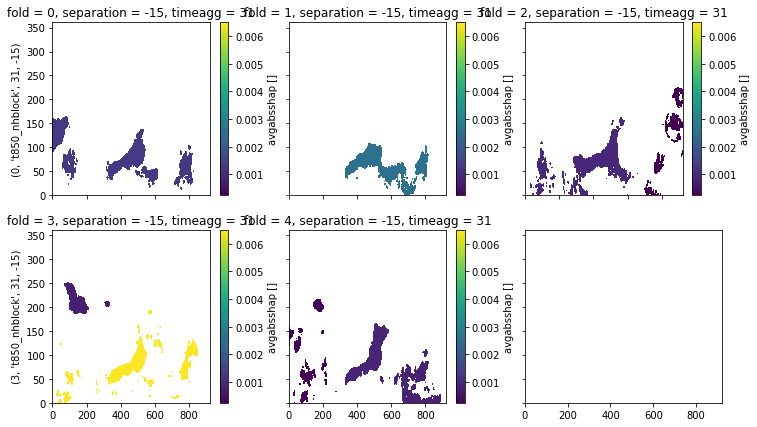

In [6]:
mapresult = mapint.map_to_fields(imp = shaps.df.loc[(31,slice(None),'t850_nhblock',31,slice(None),-15,slice(None),'mean'),:].iloc[:,0])
mapplot(mapresult, wrap_per_row=3, match_scales = True)

Now lets see the anomalies contributing to a specific moment in fold 3. Reload because we don't want global shap anymore.

In [7]:
shaps.load_data(inputpath = inputpath)

In [8]:
sample = shaps.df.loc[([31],[3],['t850_nhblock'],[31],slice(None),slice(None),slice(None),'mean'),:].iloc[:,[638]]
sample

time                                                             1987-08-26
respagg fold variable     timeagg lag separation clustid metric            
31      3    t850_nhblock 31      -46 -15        0       mean      0.012421
                                                 1       mean     -0.000906

(<Figure size 864x252 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'time = 1987-07-11'}, ylabel="(3, 't850_nhblock', 31, -15)">,
         <AxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}>,
         <AxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}>]],
       dtype=object))

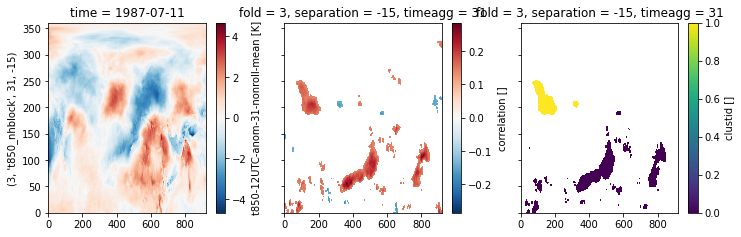

In [10]:
mapresult = mapint.get_anoms(imp=sample, mask_with_clustid=False)
mapplot(mapresult, wrap_per_row=3)

### Visualizing the number of significant cells
To test the effect of the new partial correlation and significance setup in terms of value and number of cells per variable and such

In [3]:
mapint_par = MapInterface(corclustpath=inputpath)
mapint_par.load_one_dataset('z300_nhnorm',3)
mapint_par.load_one_dataset('z300_nhnorm',7)
mapint_par.load_one_dataset('sst_nhplus',7)
#mapint_par.cache_everything()

(<Figure size 1080x252 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'timeagg: 7, fold: 3'}, xlabel='separation [days]', ylabel='fraction significant cells'>]],
       dtype=object))

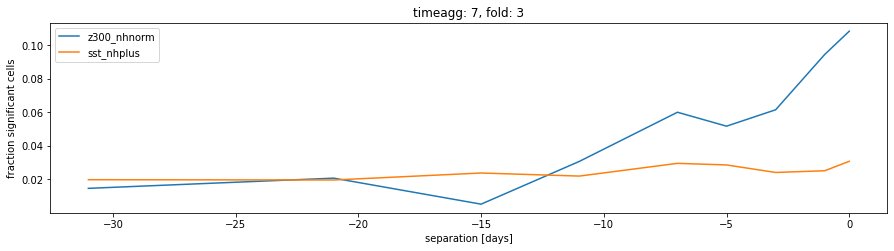

In [5]:
mapint_par.fraction_significant(plot = True, timeaggs = [7], fold = 3)

### Testing scatterplot of X vs y

In [7]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shappath, respagg=31, separation= [-15], quantile = quantile, model=model)
shaps.load_data(inputpath = inputpath, y_too=True)
shaps.global_shap() # Reduces the column axis.

(<Figure size 360x360 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'validation: 1981-06-01 - 1988-08-31, imp: 0.05'}, xlabel="(3, 'sst_nhplus', 31, -46, -15, 1, 'spatcov')", ylabel='response agg: 31'>]],
       dtype=object))

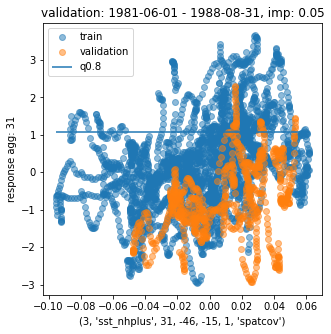

In [8]:
scatterplot(shaps, shaps.df.iloc[[shaps.df.iloc[:,0].argmax()],:], quantile = quantile)

This most important factor is supported by global shap both in training and in validation. It is interesting that with this trended response you see the validation fold have a clear vertical position depending on the timing of the validation fold (now the first, so lowest).

In [11]:
import cartopy.crs as ccrs

ModuleNotFoundError: No module named 'cartopy'